**<font size="10">Attendance at La Permanence</font>** 

<font size="4"> Monitoring the number of available seats at their two locations at rue du Fer à Moulin and rue d'Alésia</font> 

# Imports

In [1]:
import datetime
import os
import pandas as pd
import pytz
import matplotlib.pyplot as plt
%matplotlib inline

# Constants

In [2]:
tz_utc = pytz.timezone("UTC")
tz_paris = pytz.timezone("Europe/Paris")

In [3]:
days_of_the_week = {0: 'Mo', 1: 'Tu', 2: 'We', 3: 'Th', 4: 'Fr', 5: 'Sa', 6: 'Su'}

# Load data

In [4]:
dwnld_beg = datetime.datetime.now()
filepath = '/Users/antoine/Projects/la_permanence/attendance.csv'
filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=',')
dwnld_end = datetime.datetime.now()
print("Data loaded in {0} sec.".format((dwnld_end - dwnld_beg).seconds))
print("Shape of dataframe: {0}.".format(raw_data.shape))

Size of data file: 264KB.
Loading data...
Data loaded in 0 sec.
Shape of dataframe: (10209, 3).


# Preprocessing

## Adjust for timezone

In [5]:
attendance = raw_data.copy()

attendance['timestamp'] = attendance['timestamp'].apply(
    lambda s: pd.Timestamp(
        *tuple(map(int, s.split("-")))
    )
)
attendance['timestamp'] = attendance['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))

## Set timestamp to index

In [6]:
attendance.set_index("timestamp", inplace=True)

In [7]:
attendance.head(3)

,Moulin,Alésia
timestamp,,
2019-01-08 15:49:06+01:00,4,9
2019-01-08 15:52:00+01:00,4,6
2019-01-08 15:53:00+01:00,4,6


# Visualize

The data was collected at irregular times, as can be seen by the following graph.

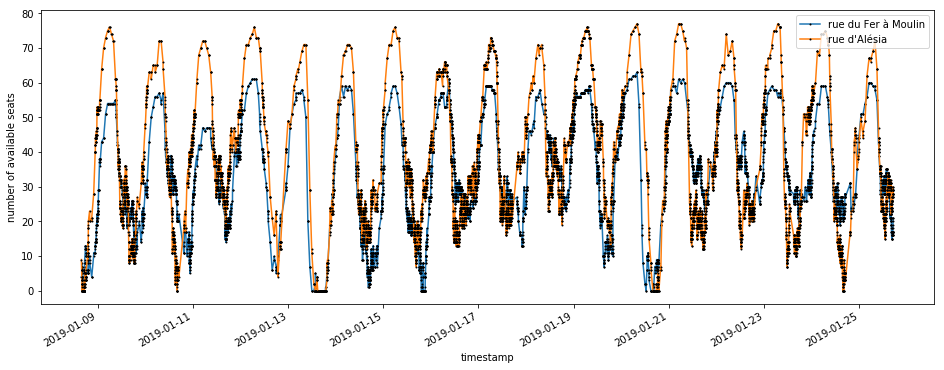

In [8]:
fig, ax = plt.subplots(figsize=(16, 6));
attendance.plot(ax=ax, style='-o', **{"markersize": 1, "markerfacecolor": "k", "markeredgecolor": "k"});
plt.ylabel("number of available seats");
ax.legend(["rue du Fer à Moulin", "rue d'Alésia"]);

# Time regularization

Resample (at a resolution of 10 minutes) and interpolate to regularize the data.

In [9]:
attendance = attendance.resample("10T").mean().interpolate()

In [10]:
attendance.head()

,Moulin,Alésia
timestamp,,
2019-01-08 15:40:00+01:00,4.000,9.000
2019-01-08 15:50:00+01:00,4.125,5.375
2019-01-08 16:00:00+01:00,6.500,2.800
2019-01-08 16:10:00+01:00,5.400,0.700
2019-01-08 16:20:00+01:00,1.500,0.000


# Visualize (again)

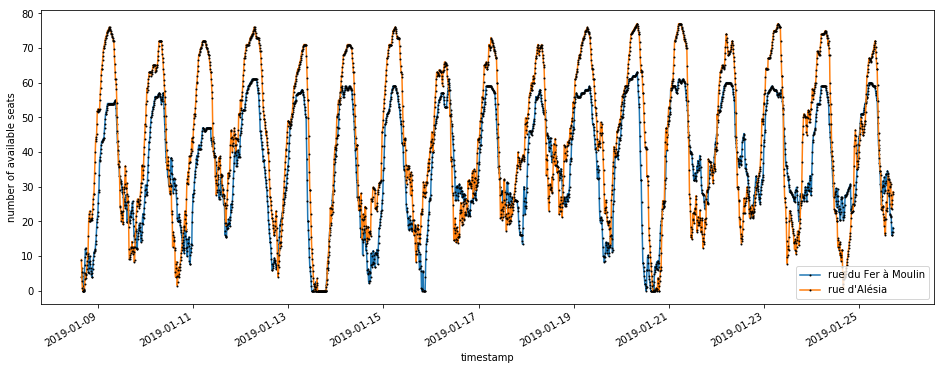

In [11]:
fig, ax = plt.subplots(figsize=(16, 6));
attendance[['Moulin', 'Alésia']].plot(ax=ax, style='-o', **{"markersize": 1, "markerfacecolor": "k", "markeredgecolor": "k"});
plt.ylabel("number of available seats");
ax.legend(["rue du Fer à Moulin", "rue d'Alésia"]);

# Averaging

Our next goal is to have a representative day.  For this, we introduce two more columns.

In [12]:
attendance['day of week'] = attendance.index.dayofweek.map(days_of_the_week)
attendance['hour of day'] = attendance.index.hour
#attendance.head()

In [13]:
attendance_by_hour_of_day = attendance.groupby(by=['hour of day']).mean()

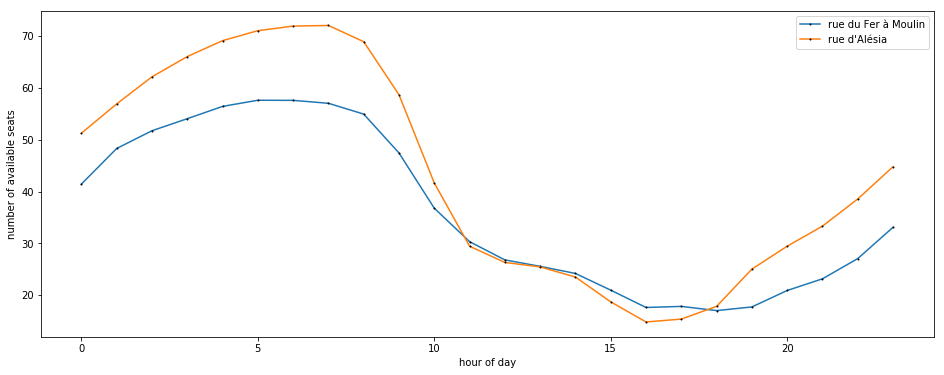

In [14]:
fig, ax = plt.subplots(figsize=(16, 6));
attendance_by_hour_of_day.plot(ax=ax, style='-o', **{"markersize": 1, "markerfacecolor": "k", "markeredgecolor": "k"});
plt.ylabel("number of available seats");
ax.legend(["rue du Fer à Moulin", "rue d'Alésia"]);

In [15]:
attendance_by_day_of_week = attendance.groupby(by=['day of week', 'hour of day']).mean()

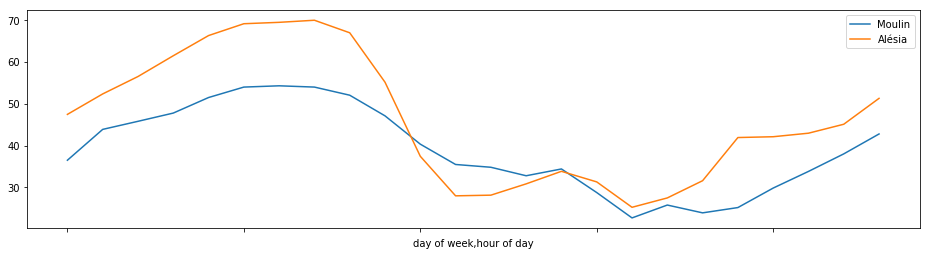

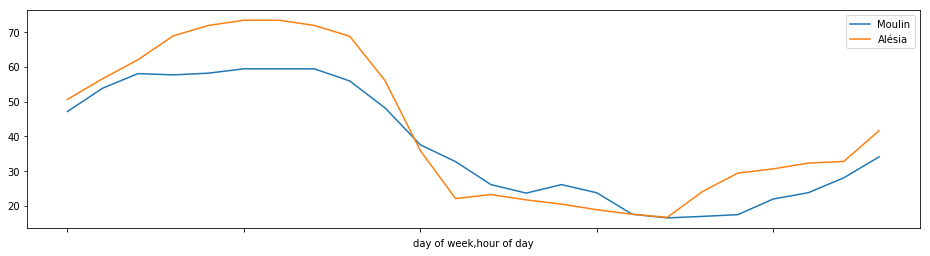

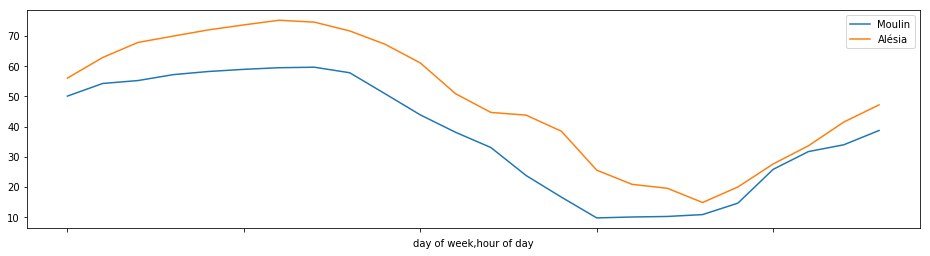

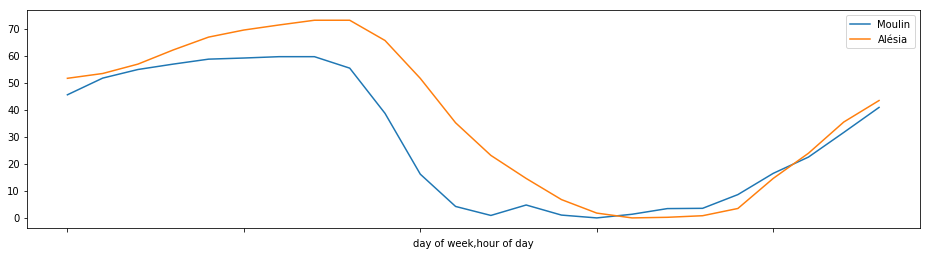

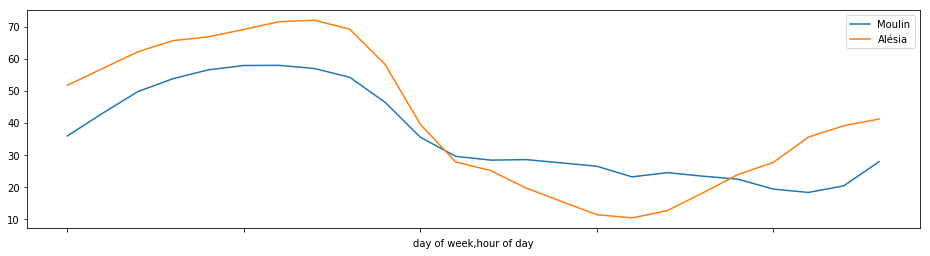

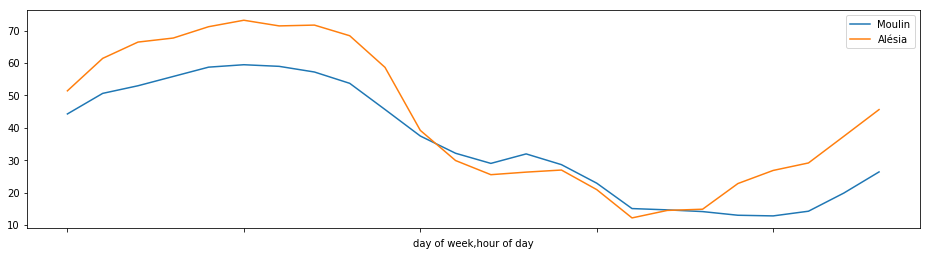

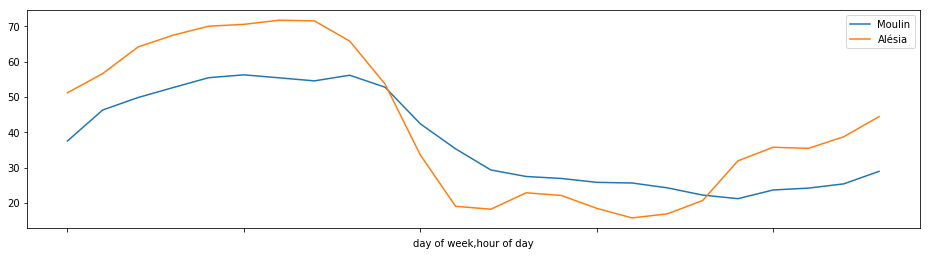

In [16]:
attendance_by_day_of_week.groupby(by=['day of week']).plot(figsize=(16, 4));